## Setting Up

In [24]:
import os
import glob
import random
from tqdm import tqdm

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

from PIL import Image
import pytesseract
import pickle

In [25]:
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(ROOT_DIR, "data")
OUTPUT_DIR = os.path.join(ROOT_DIR, "backend", "model")

os.makedirs(OUTPUT_DIR, exist_ok=True)

seed = 7
random.seed(seed)

## Prepare Data

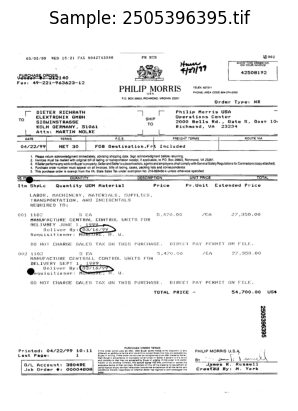

In [15]:
from typing import Union
import matplotlib.pyplot as plt

def read_and_show_image(path: str) -> None:
    """Open a file and display it."""
    img = Image.open(path)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"Sample: {os.path.basename(path)}")
    plt.show()

sample_path = glob.glob(os.path.join(DATA_DIR, "invoice", "*.tif"))[0]
read_and_show_image(sample_path)


In [16]:
def ocr_image(path: str) -> str:
    """Extract text from a single image file."""
    img = Image.open(path)
    text = pytesseract.image_to_string(img)
    return text.strip()

print(ocr_image(sample_path)[:500])


05/05/99 WED 15:21 FAX 8042749586 PM rs

¥

EERE SPREE 140

Fax: 49-221-963623-12

7 ‘42508192

PHILIP MORRIS ss:

00% 03, EUOND, VINA 2261
Order Type: NR

[- DIETER RICHRATH | Philip Horris usa -
ro. ELEKTRONIK GHBH ship Operations Center
SIGUINSTRASSE tO 2000 Bells Rd., Gate S, Door 10
KOLN GERMANY, 51061 Richmond, VA 29234
Attn: MARTIN NOLKE Jk
oa eas fo 1 Fen Teas

1. Pasa rtm scnowtedgnent immedi, acving shipping ae. Sign acknowledgment eke etuig.
2, totes must be ale wit ginal i lang of ra


In [19]:
for cls in os.listdir(DATA_DIR):
    n = len(os.listdir(os.path.join(DATA_DIR, cls)))
    print(f"Class '{cls}': {n} samples")

Class 'invoice': 2477 samples
Class 'resume': 2536 samples
Class 'email': 2516 samples


In [22]:
def build_dataset(data_dir: str) -> pd.DataFrame:
    """OCR all images in data_dir, return DataFrame with text + label."""
    records = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if not os.path.isdir(label_dir):
            continue
        files = glob.glob(os.path.join(label_dir, "*.tif"))
        for f in tqdm(files, desc=f"Processing {label}"):
            text = ocr_image(f)
            records.append({"text": text, "label": label})
            
        print(f"Processed {len(files)} files for class '{label}'")
    return pd.DataFrame(records)

df = build_dataset(DATA_DIR)
df.head()

Processing invoice: 100%|██████████| 2477/2477 [38:31<00:00,  1.07it/s] 


Processed 2477 files for class 'invoice'


Processing resume: 100%|██████████| 2536/2536 [1:32:58<00:00,  2.20s/it]  


Processed 2536 files for class 'resume'


Processing email: 100%|██████████| 2516/2516 [30:48<00:00,  1.36it/s] 

Processed 2516 files for class 'email'


,text,label
0,05/05/99 WED 15:21 FAX 8042749586 PM rs\n\n¥\n...,invoice
1,arenes ci\n\nHe ro woxiow ADVERTISING AND\nAME...,invoice
2,"2024967939\n\nMUZOOET SLOOMNZ00OT2tH wSObbOO""...",invoice
3,O companes\n\neaPrtat cone. PHILIP MORRIS fron...,invoice
4,")SEP-24-61 10,54 FROM: 1D PAGE 14/26.\n\na ear...",invoice


In [27]:
df.sample(5, random_state=seed)

,text,label
1997,or\n\nuuoa ouebe e807\n\nHO “ON JoEDWVOD\n\noN...,invoice
7095,"From: JAMES SANDMAN on Thu, Sep 12, 1996 11:24...",email
4983,PAMELA V. GUTMAN\n\nSenior Consultant\n‘Techno...,resume
4295,"Biography: Nancy A. Higley, Ph.D.\n\nNancy rec...",resume
2622,. page.\n\nBiographical Information\nLast name...,resume


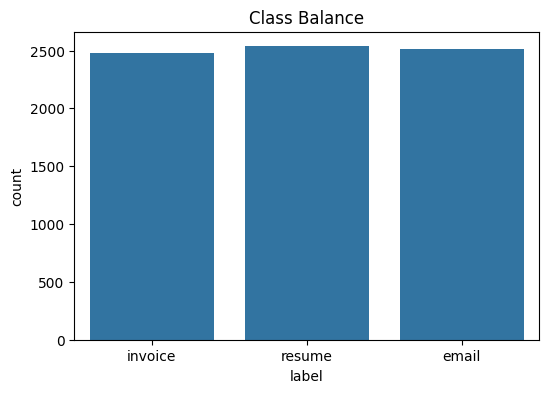

In [28]:
import seaborn as sns

def plot_class_balance(data: pd.DataFrame):
    plt.figure(figsize=(6,4))
    sns.countplot(x="label", data=data)
    plt.title("Class Balance")
    plt.show()

plot_class_balance(df)

In [29]:
DATASET_PATH = os.path.join(ROOT_DIR, "data", "dataset.csv")

def save_dataset(df: pd.DataFrame, path: str = DATASET_PATH):
    df.to_csv(path, index=False)
    print(f"✅ Dataset saved to {path}")

save_dataset(df)


✅ Dataset saved to /home/administrator/test/pdf/data/dataset.csv


## Vectorize & Train

In [30]:
def vectorize_texts(df: pd.DataFrame):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    X = vectorizer.fit_transform(df["text"])
    y = df["label"]
    return X, y, vectorizer

X, y, vectorizer = vectorize_texts(df)
print("✅ Vectorization complete:", X.shape)

✅ Vectorization complete: (7529, 5000)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (6776, 5000), Test: (753, 5000)


In [32]:
def train_classifier(X_train, y_train):
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    return clf

clf = train_classifier(X_train, y_train)
print("✅ Model training complete")

✅ Model training complete


In [33]:
y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

       email       0.98      0.98      0.98       251
     invoice       0.94      0.96      0.95       248
      resume       0.98      0.95      0.97       254

    accuracy                           0.97       753
   macro avg       0.97      0.97      0.97       753
weighted avg       0.97      0.97      0.97       753

=== Confusion Matrix ===
[[246   5   0]
 [  4 239   5]
 [  2  10 242]]


In [34]:
def save_artifacts(model, vectorizer, out_dir=OUTPUT_DIR):
    model_path = os.path.join(out_dir, "trained_model.pkl")
    vec_path = os.path.join(out_dir, "vectorizer.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(model, f)
    with open(vec_path, "wb") as f:
        pickle.dump(vectorizer, f)

    print(f"✅ Saved model to {model_path}")
    print(f"✅ Saved vectorizer to {vec_path}")

save_artifacts(clf, vectorizer)

✅ Saved model to /home/administrator/test/pdf/backend/model/trained_model.pkl
✅ Saved vectorizer to /home/administrator/test/pdf/backend/model/vectorizer.pkl


In [37]:
def predict_sample(text: str, model, vectorizer):
    X = vectorizer.transform([text])
    return model.predict(X)[0]

sample_text = df.iloc[50]["text"]
print("Sample text prediction:", predict_sample(sample_text, clf, vectorizer))

Sample text prediction: invoice
